# **Installation**

Install Python package that provide ready-to-use stop words

In [1]:
!pip install stop-words

  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=f7635d1c3ac5cf2467bd87447d732e99d18b7409faa7a989f0e13796767abe05
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


# **Import**

In [2]:
import os
import pandas as pd
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.datasets import fetch_20newsgroups

from stop_words import get_stop_words

Define path to videos

In [3]:
path_to_videos = '/content/drive/MyDrive/Brut/'

# **Create text for Topic Modelling**

In this section, we construct video text by concatening all video comments

In [4]:
df_videos = pd.read_csv(f'{path_to_videos}/videos.csv')
df_videos = df_videos.loc[df_videos['published'] == '1 month ago']
df_comments = pd.read_csv(f'{path_to_videos}/comments.csv')
df_comments['comment'] = df_comments['comment'].astype(str)
df = pd.merge(df_videos, df_comments, on='link')

In [5]:
df["text"] = df[["link", "comment"]].groupby('link')['comment'].transform(lambda x : ' '.join(x))

In [6]:
df = df.drop_duplicates('text')

We can drop comments now

In [7]:
df = df.drop(['comment'], axis=1)

In [8]:
df.head()

,title,link,views,published,thumbnail,likes,text
0,On a demandé à Robert Pattinson qui est son mé...,https://www.youtube.com/shorts/-hZtpDwkoo0,17000.0,1 month ago,https://i.ytimg.com/vi/-hZtpDwkoo0/hqdefault.jpg,503.0,Le budget voix off est à zéro ouvrez les dons ...
6,Ils transforment des mégots de cigarette en ce...,https://www.youtube.com/watch?v=jH0HHRI7uIU,81000.0,1 month ago,https://i.ytimg.com/vi/jH0HHRI7uIU/hqdefault.jpg,1200.0,"Belle initiative, y’en a qui ont de bonne idée..."
69,"Ciel orange, montagnes de ski ensablées… Ces p...",https://www.youtube.com/shorts/fK6aW_U0E4M,18000.0,1 month ago,https://i.ytimg.com/vi/fK6aW_U0E4M/hqdefault.jpg,602.0,J’habite à cauterets et la bas aussi il y’a be...
76,Des chatons sauvés de justesse par des éboueurs,https://www.youtube.com/watch?v=Y74RQXpuK3c,143000.0,1 month ago,https://i.ytimg.com/vi/Y74RQXpuK3c/hqdefault.jpg,2100.0,Hyper émouvant la gentillesse de nos héros du ...
233,Un journal télévisé russe interrompu avec une ...,https://www.youtube.com/shorts/KHp4cosw3HQ,22000.0,1 month ago,https://i.ytimg.com/vi/KHp4cosw3HQ/hqdefault.jpg,939.0,"Un courage exceptionnel, elle risque son métie..."


# **Text vectorization**

In this section, we define various document-word matrix to be feed to a clustering method:

*  TF matrix

*  TFIDF matrix

In [9]:
n_samples = 2000
n_features = 500
n_components = 5
n_top_words = 20


def plot_top_words(model, feature_names, n_top_words, title):
    """util function to plot word distribution for each topic found
    """
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


Load stop words from Python package and add homemade words (stop_words.txt) if provided

In [13]:
stop_words = get_stop_words('french')
homemade_stop_words_file = f'{path_to_videos}/stop_words.txt'
if os.path.exists(homemade_stop_words_file):
    stop_words_ = open(homemade_stop_words_file, 'r').readlines()
    stop_words_ = [w.strip() for w in stop_words_]
    stop_words = set(stop_words_+stop_words)

**TFIDF**

In [14]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words=stop_words
)

In [15]:
tfidf = tfidf_vectorizer.fit_transform(df['text'])

### **TF**

In [16]:
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words=stop_words
)

In [17]:
tf = tf_vectorizer.fit_transform(df['text'].values)

# **Topic Clustering**

### **Non-Negative Matrix Factorization (Frobenius norm)**

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


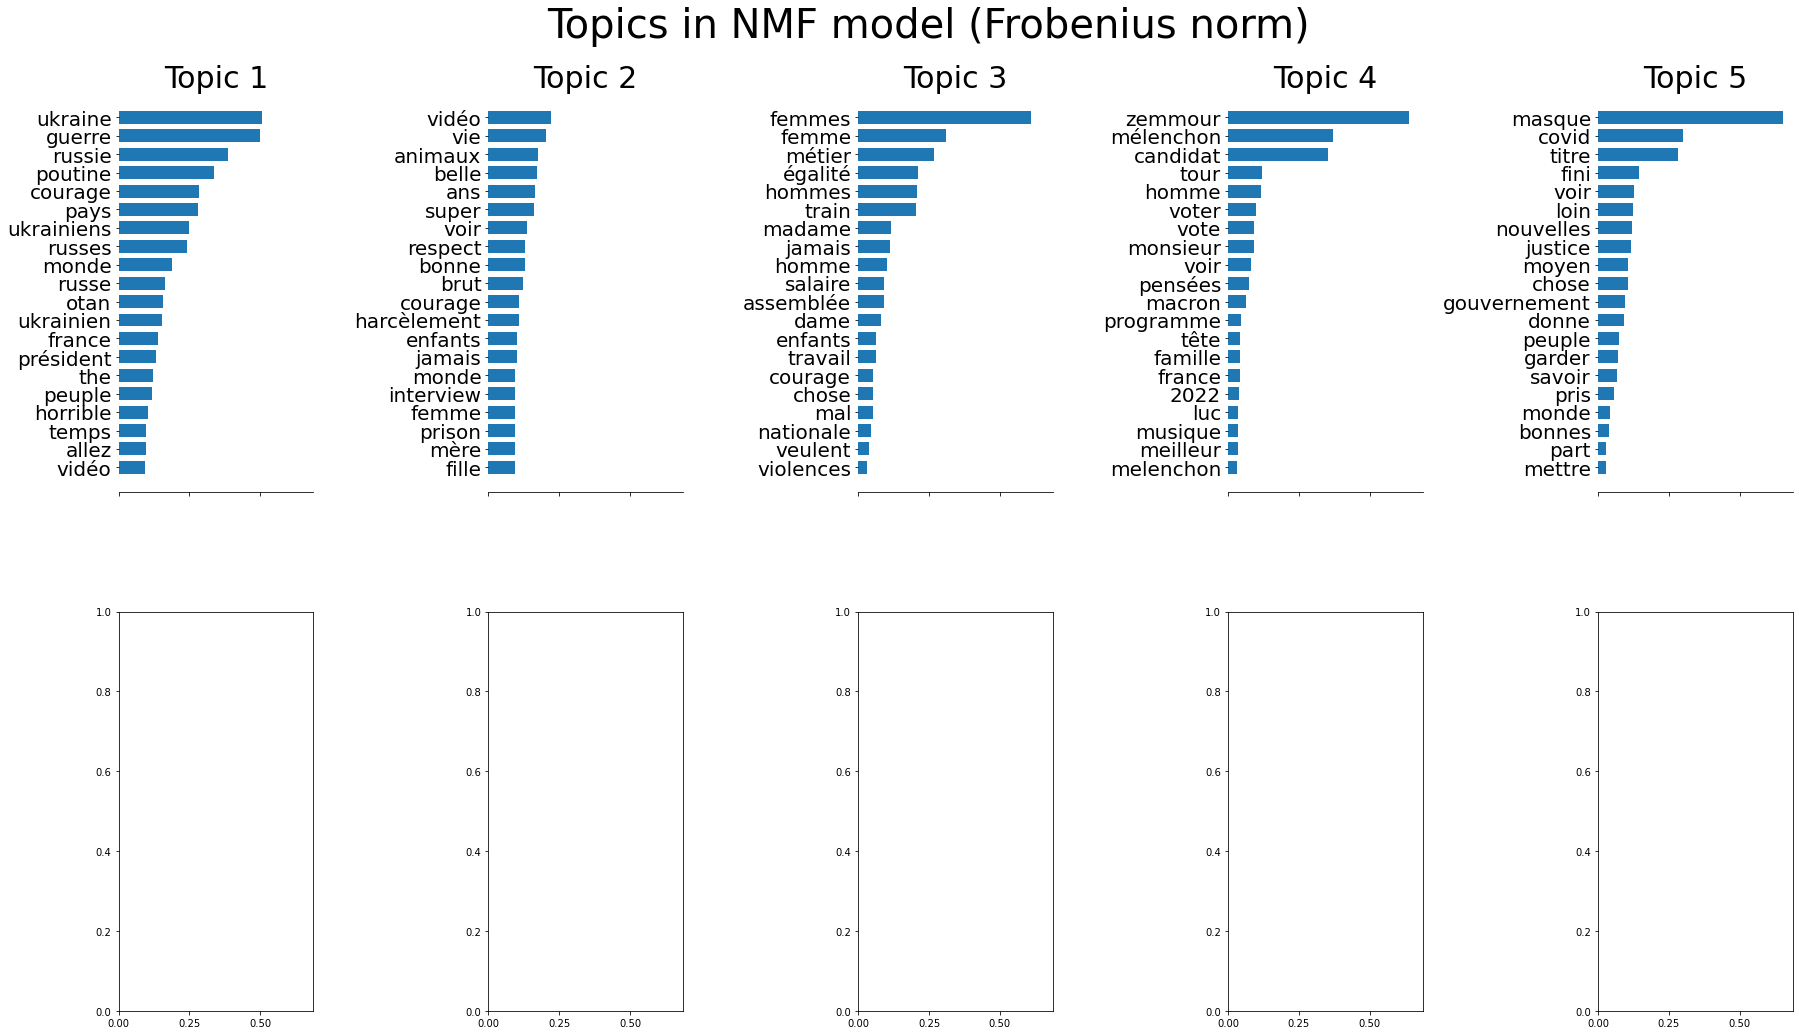

In [19]:
nmf = NMF(n_components=n_components, random_state=1, alpha=0.1, l1_ratio=0.5).fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

### **Latent Dirichlet Allocation**

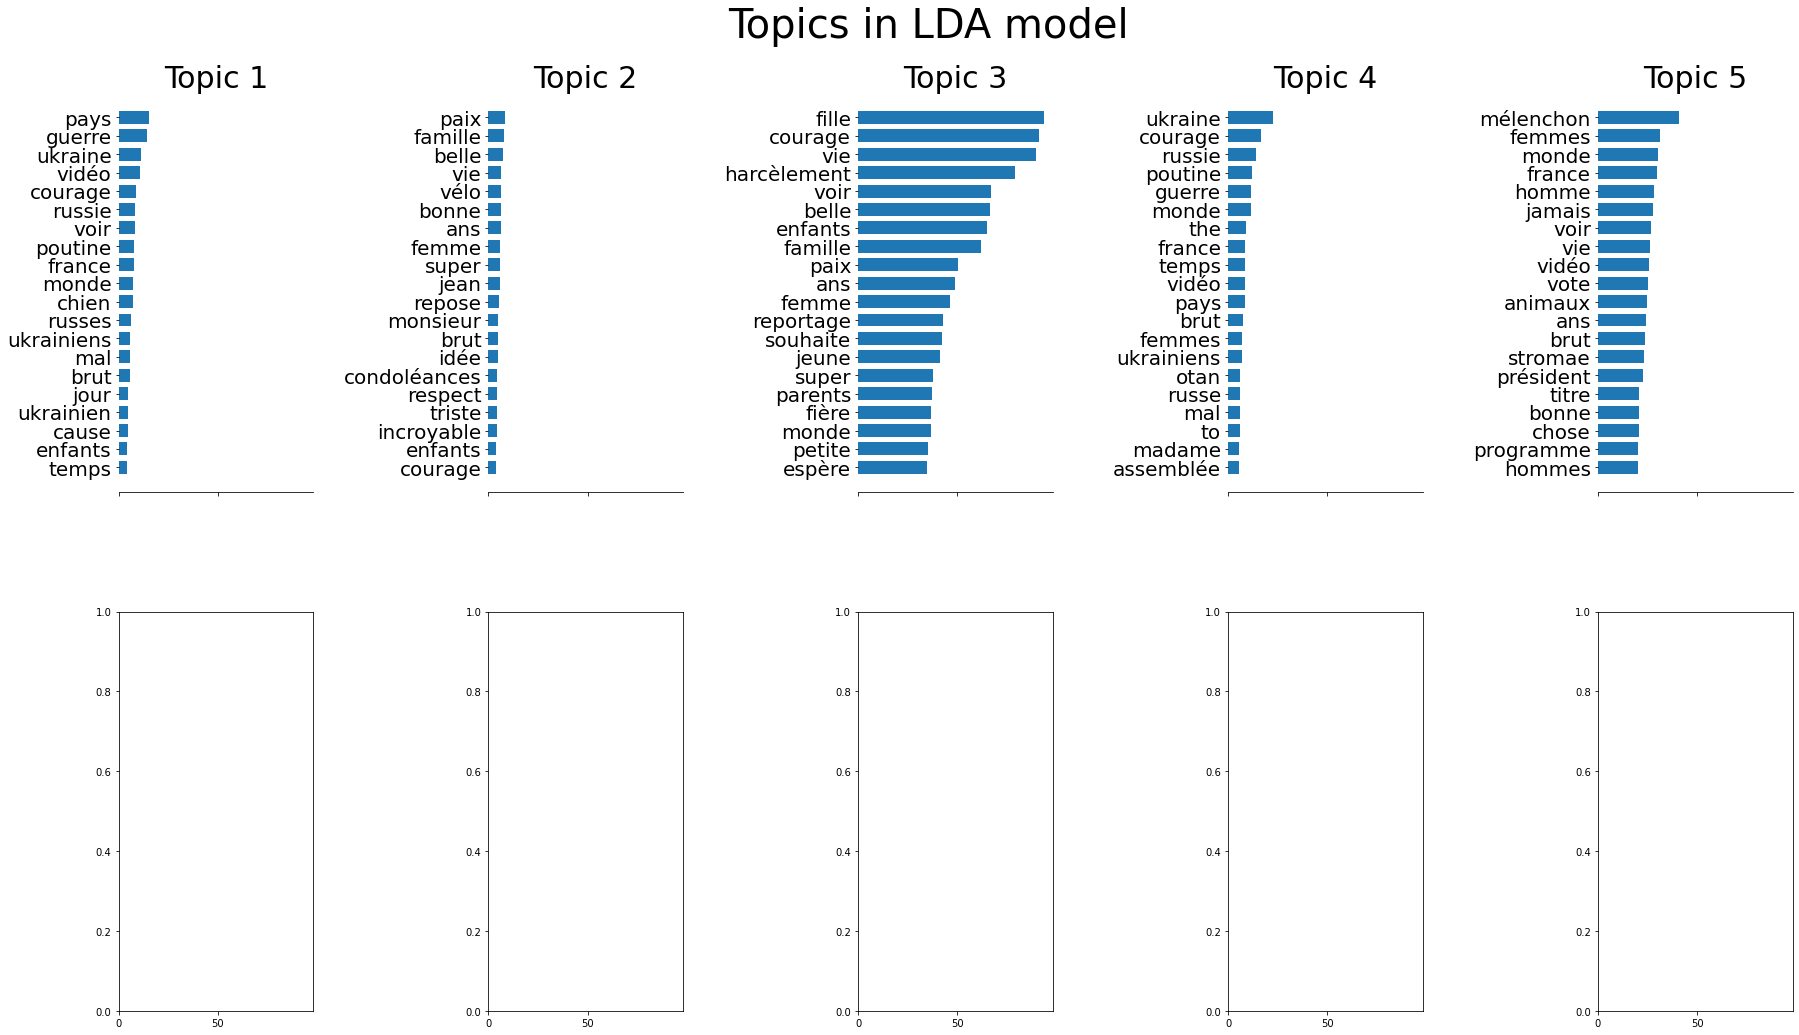

In [21]:
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=10.0,
    random_state=0,
)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")